In [17]:
import sys
!{sys.executable} -m pip install nltk wordcloud tensorflow scikit-learn keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matchalatte2609/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0

In [4]:
data.shape

(5171, 4)

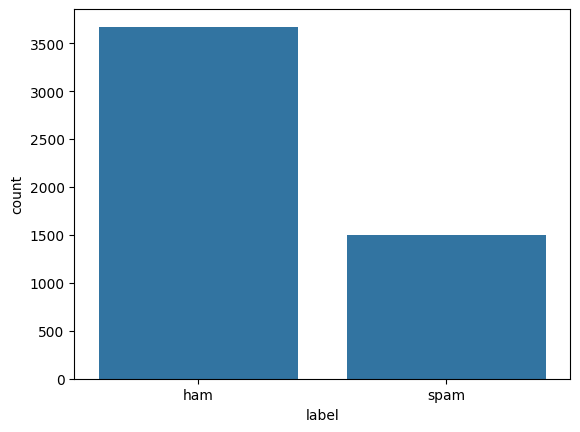

In [5]:
sns.countplot(x='label', data=data)
plt.show()

In [6]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to address the imbalance
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

#Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# plot to check if balanced
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced dist")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

In [7]:
#Clean the text, notice that it all starts with subject
balanced_data.head()

Unnamed: 0 label                                               text  \
0        3444   ham  Subject: conoco - big cowboy\r\ndarren :\r\ni ...   
1        2982   ham  Subject: feb 01 prod : sale to teco gas proces...   
2        2711   ham  Subject: california energy crisis\r\ncaliforni...   
3        3116   ham  Subject: re : nom / actual volume for april 23...   
4        1314   ham  Subject: eastrans nomination changes effective...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0

In [8]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

Unnamed: 0 label                                               text  \
0        3444   ham  : conoco - big cowboy\r\ndarren :\r\ni ' m not...   
1        2982   ham  : feb 01 prod : sale to teco gas processing\r\...   
2        2711   ham  : california energy crisis\r\ncalifornia  , s...   
3        3116   ham  : re : nom / actual volume for april 23 rd\r\n...   
4        1314   ham  : eastrans nomination changes effective 8 / 2 ...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0

In [9]:
#then there are still punctuations
punc_list = string.punctuation
def remove_punctuations(text):
    #chars replace, replacement one, then chars to delete, we pass punc_list to the end
    temp = str.maketrans('', '', punc_list)
    return text.translate(temp)
balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

Unnamed: 0 label                                               text  \
0        3444   ham   conoco  big cowboy\r\ndarren \r\ni  m not sur...   
1        2982   ham   feb 01 prod  sale to teco gas processing\r\ns...   
2        2711   ham   california energy crisis\r\ncalifornia   s p...   
3        3116   ham   re  nom  actual volume for april 23 rd\r\nwe ...   
4        1314   ham   eastrans nomination changes effective 8  2  0...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0

In [10]:
# using nltk english stopwords to filter words like a, an, the, etc.
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    #store the meaningful one
    for word in str(text).split():
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

        

Unnamed: 0 label                                               text  \
0        3444   ham  conoco big cowboy darren sure help know else a...   
1        2982   ham  feb 01 prod sale teco gas processing sale deal...   
2        2711   ham  california energy crisis california  power cr...   
3        3116   ham  nom actual volume april 23 rd agree eileen pon...   
4        1314   ham  eastrans nomination changes effective 8 2 00 p...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0

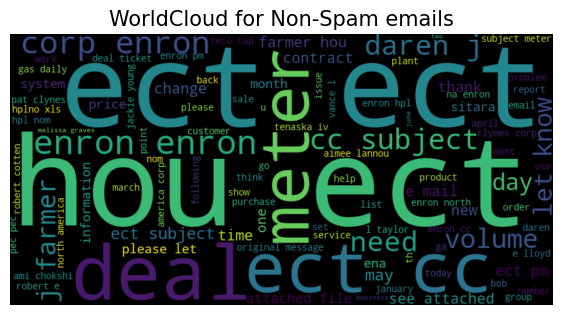

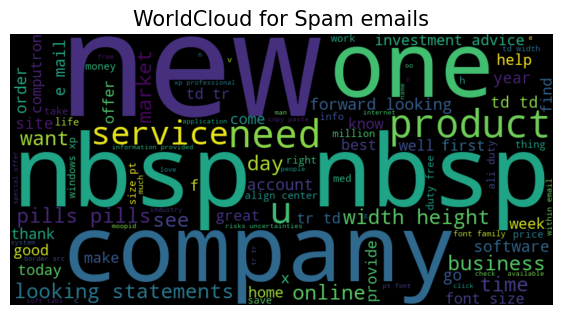

In [11]:
# visualize wo5rd cloud
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black',
                    max_words=100,
                    width=800,
                    height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WorldCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [12]:
#split data set
X_train, X_test, y_train, y_test = train_test_split(balanced_data['text'], balanced_data['label'], 
                                                    test_size=0.2, random_state=42)

In [13]:
#tokenization to convert word into an integer
#padding to ensure all text sequence have the same length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100 #for sequence length
train_seq = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')
test_seq = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

y_train = (y_train == 'spam').astype(int)
y_test = (y_test == 'spam').astype(int)

In [18]:
#model using sequential architecture
#Embedding Layer: Learns vector representations of words.
# LSTM Layer: Captures patterns in sequences.
# Fully Connected Layer: Extracts relevant features.
# Output Layer: Predicts whether an email is spam or not.
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') #output layer
])

model.build(input_shape=(None, max_length))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 32)        │     1,274,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#train the model
#EarlyStopping and ReduceLROnPlateau are callbacks to stop the training early if the performance doesn't improve
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

pipeline = model.fit(
    train_seq, y_train,
    validation_data=(test_seq, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5951 - loss: 0.6710 - val_accuracy: 0.9667 - val_loss: 0.3881 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9558 - loss: 0.2081 - val_accuracy: 0.9567 - val_loss: 0.1736 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9637 - loss: 0.1431 - val_accuracy: 0.9550 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9058 - loss: 0.2591 - val_accuracy: 0.9167 - val_loss: 0.2263 - learning_rate: 0.0010


In [20]:
test_loss, test_accuracy = model.evaluate(test_seq, y_test)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9667 - loss: 0.3881
Test Loss:  0.3881431221961975
Test Accuracy:  0.9666666388511658


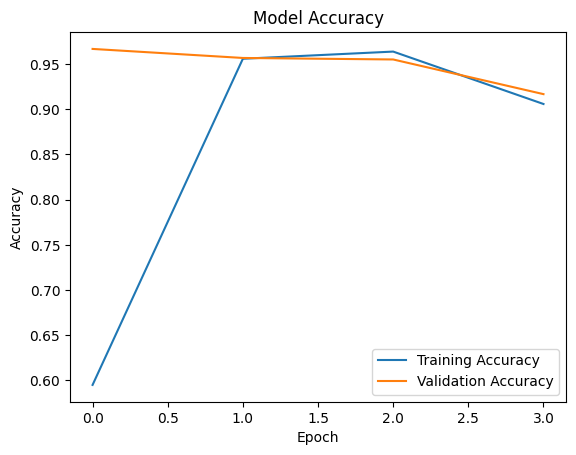

In [22]:
plt.plot(pipeline.history['accuracy'], label='Training Accuracy')
plt.plot(pipeline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()